In [1]:
import os 
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.spatial import Voronoi, ConvexHull
from shapely.geometry import MultiPoint, Point, Polygon
from scipy.spatial import voronoi_plot_2d

# import custom functions
os.chdir('..')
from RuckFunctions import DataLoading, Preprocessing, SpatialFeats


Load data

In [2]:
# Initialize path to data (UTM-converted datasets)
data_dir = os.getcwd() + '\\SampleData'

# Load datasets
raw_datasets = DataLoading.load_data(data_dir)

# Re-shape datasets
datasets = DataLoading.pivot_datsets(raw_datasets)

Get the interpolated data

In [3]:
# get interpolated datasets
interp_datasets = Preprocessing.interpolate_datasets(datasets, threshold = 0.99)

Get movement periods


In [4]:
# get slices for movement periods and break times   
rucks_bySquad, rests_bySquad, all_stops = Preprocessing.get_slices_byArea(interp_datasets, plot=False)

Get the smoothed data of one example squad


In [5]:
smooth_rucks = Preprocessing.spline_smoothing(rucks_bySquad[1], s=3e1, UTM=True)

Get stretch index over time<br>(each individual's distance to centroid)

In [6]:
cent_dists = SpatialFeats.get_cent_dist(smooth_rucks) 

neighbor_ds = SpatialFeats.neighbor_dists(smooth_rucks)

SAs = SpatialFeats.get_surface_area(smooth_rucks) 

voronoi_areas, voronoi_ratios = SpatialFeats.get_voronoi_areas(smooth_rucks)

  0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 7/7 [03:59<00:00, 34.18s/it]


Plot some spatial features here

In [7]:
random_period = np.random.randint(len(smooth_rucks))
random_timepoint = np.random.randint(len(smooth_rucks[random_period]))

In [8]:
example_ruck = smooth_rucks[random_period]
example_timepoint = example_ruck.iloc[random_timepoint]

In [9]:
cent_dists_ex = cent_dists[random_period].iloc[random_timepoint]

In [91]:
# get UTM points for this squad at this timepoint
points = [[example_timepoint['UTM_x',S], example_timepoint['UTM_y',S]] for S in example_timepoint['UTM_x'].index]

# normalize points
points = np.array(points) - np.mean(np.array(points), axis=0)

# Calculate Voronoi diagram
vor = Voronoi(points)

# get regions and vertices
regions, vertices = SpatialFeats.voronoi_finite_polygons_2d(vor)

# Create 'points' object
pts = MultiPoint([Point(i) for i in points])

# create convex hull mask
mask = pts.convex_hull

In [134]:
# define colors for all plots 
names = smooth_rucks[0].latitude.columns.tolist()
color_dictionary = dict(zip(names, sns.color_palette(as_cmap=True)[:len(names)]))

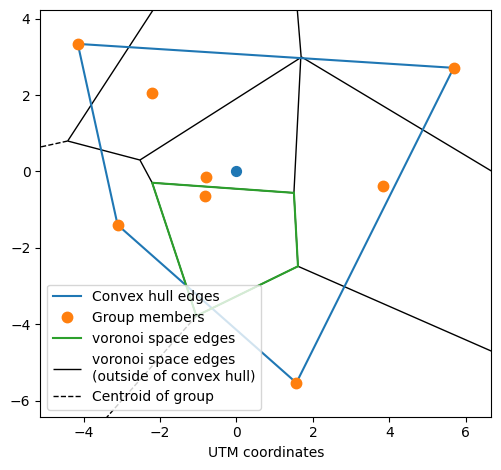

In [151]:

x,y = mask.exterior.xy
plt.plot(x,y)

fig = voronoi_plot_2d(vor, ax=plt.gca(), point_size=15, show_vertices=False, c = [color_dictionary[n] for n in names])

# fig = voronoi_plot_2d(vor, ax=plt.gca(), point_size=0, show_vertices=False, c = [color_dictionary[n] for n in names])

# plt.scatter([p[0] for p in points], [p[1] for p in points], c = [color_dictionary[n] for n in names], s=100)

# plt.gca().set_ylabel('UTM y')
plt.gca().set_xlabel('UTM coordinates')

plt.scatter(x=0, y=0, s=50)

x,y = Polygon(vertices[regions[4]]).exterior.xy
plt.plot(x,y, fillstyle='full')

plt.legend(['Convex hull edges', 'Group members', 'voronoi space edges', 'voronoi space edges\n(outside of convex hull)', 'Centroid of group'], loc='lower left')

plt.tight_layout()
plt.gca().set_aspect(1)

Plot spatial metrics separately

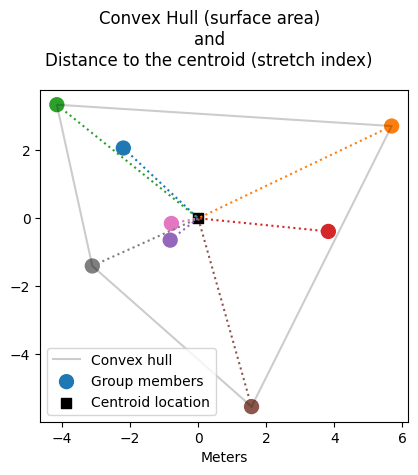

In [254]:
# centorid distance

plt.scatter([p[0] for p in points], [p[1] for p in points], c = [color_dictionary[n] for n in names], s=100, label='Group members')
plt.scatter(0,0, label='Centroid location', marker='s', color='k', s=50)

# [plt.arrow(p[0] , p[1], -p[0]/3, -p[1]/3, width=0.1, length_includes_head=False, color='k') for p in points]
[plt.plot((p[0],0) , (p[1],0), ls=':') for p in points]

x,y = mask.exterior.xy
plt.plot(x,y, label='Convex hull', c='k', alpha=0.2)

plt.legend()

plt.xlabel('Meters')

plt.suptitle('Convex Hull (surface area)\nand\nDistance to the centroid (stretch index)')
plt.tight_layout()
plt.gca().set_aspect(1)

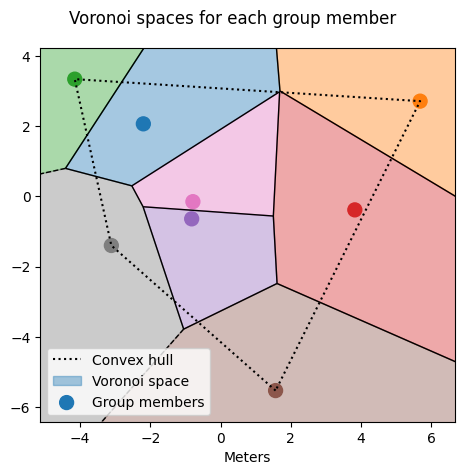

In [255]:

fig = voronoi_plot_2d(vor, ax=plt.gca(), point_size=0, show_vertices=False, c = [color_dictionary[n] for n in names])

plt.scatter([p[0] for p in points], [p[1] for p in points], c = [color_dictionary[n] for n in names], s=100, label='Group members')


x,y = mask.exterior.xy
plt.plot(x,y, label='Convex hull', ls=':', c='k')#, alpha=0.5)

for r, n in zip(regions, names):
    x,y = Polygon(vertices[r]).exterior.xy
    if n==names[0]:
        plt.fill(x,y, c=color_dictionary[n], alpha=0.4, label='Voronoi space')
    else:
        plt.fill(x,y, c=color_dictionary[n], alpha=0.4)



plt.legend(loc='lower left')

plt.xlabel('Meters')

plt.suptitle('Voronoi spaces for each group member')
plt.tight_layout()
plt.gca().set_aspect(1)